In [1]:
cd /home

/home


In [231]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
import toml
import umap
import os 

from presentation.pipelines.steps.model_design import load_pt_model
from presentation.pipelines.steps.load_data import build_loader

from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
path = './presentation/results/lfgr/2024-04-05_14-31-32/pretraining/'

with open(os.path.join(path, 'config.toml'), 'r') as file:
    params = toml.load(file)
params['mask_format'], params['probed'], params['rs'], params['arch'], params['m_alpha']

('QK', 0.5, 0.2, 'zero', 1.0)

In [316]:
astromer, config = load_pt_model(path)

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


In [317]:
loaders = build_loader(params['data'], 
                       params, 
                       batch_size=16,
                       debug=False,
                       sampling=False)

[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


In [318]:
for x, y in loaders['test'].take(1):
#     x['mask_in'] = new_mask
    z, w, qkvalues = astromer.get_layer('encoder')(x, return_weights=True)
    x_rec = astromer.get_layer('regression')(z)

[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


Text(0.5, 1.0, 'Logits')

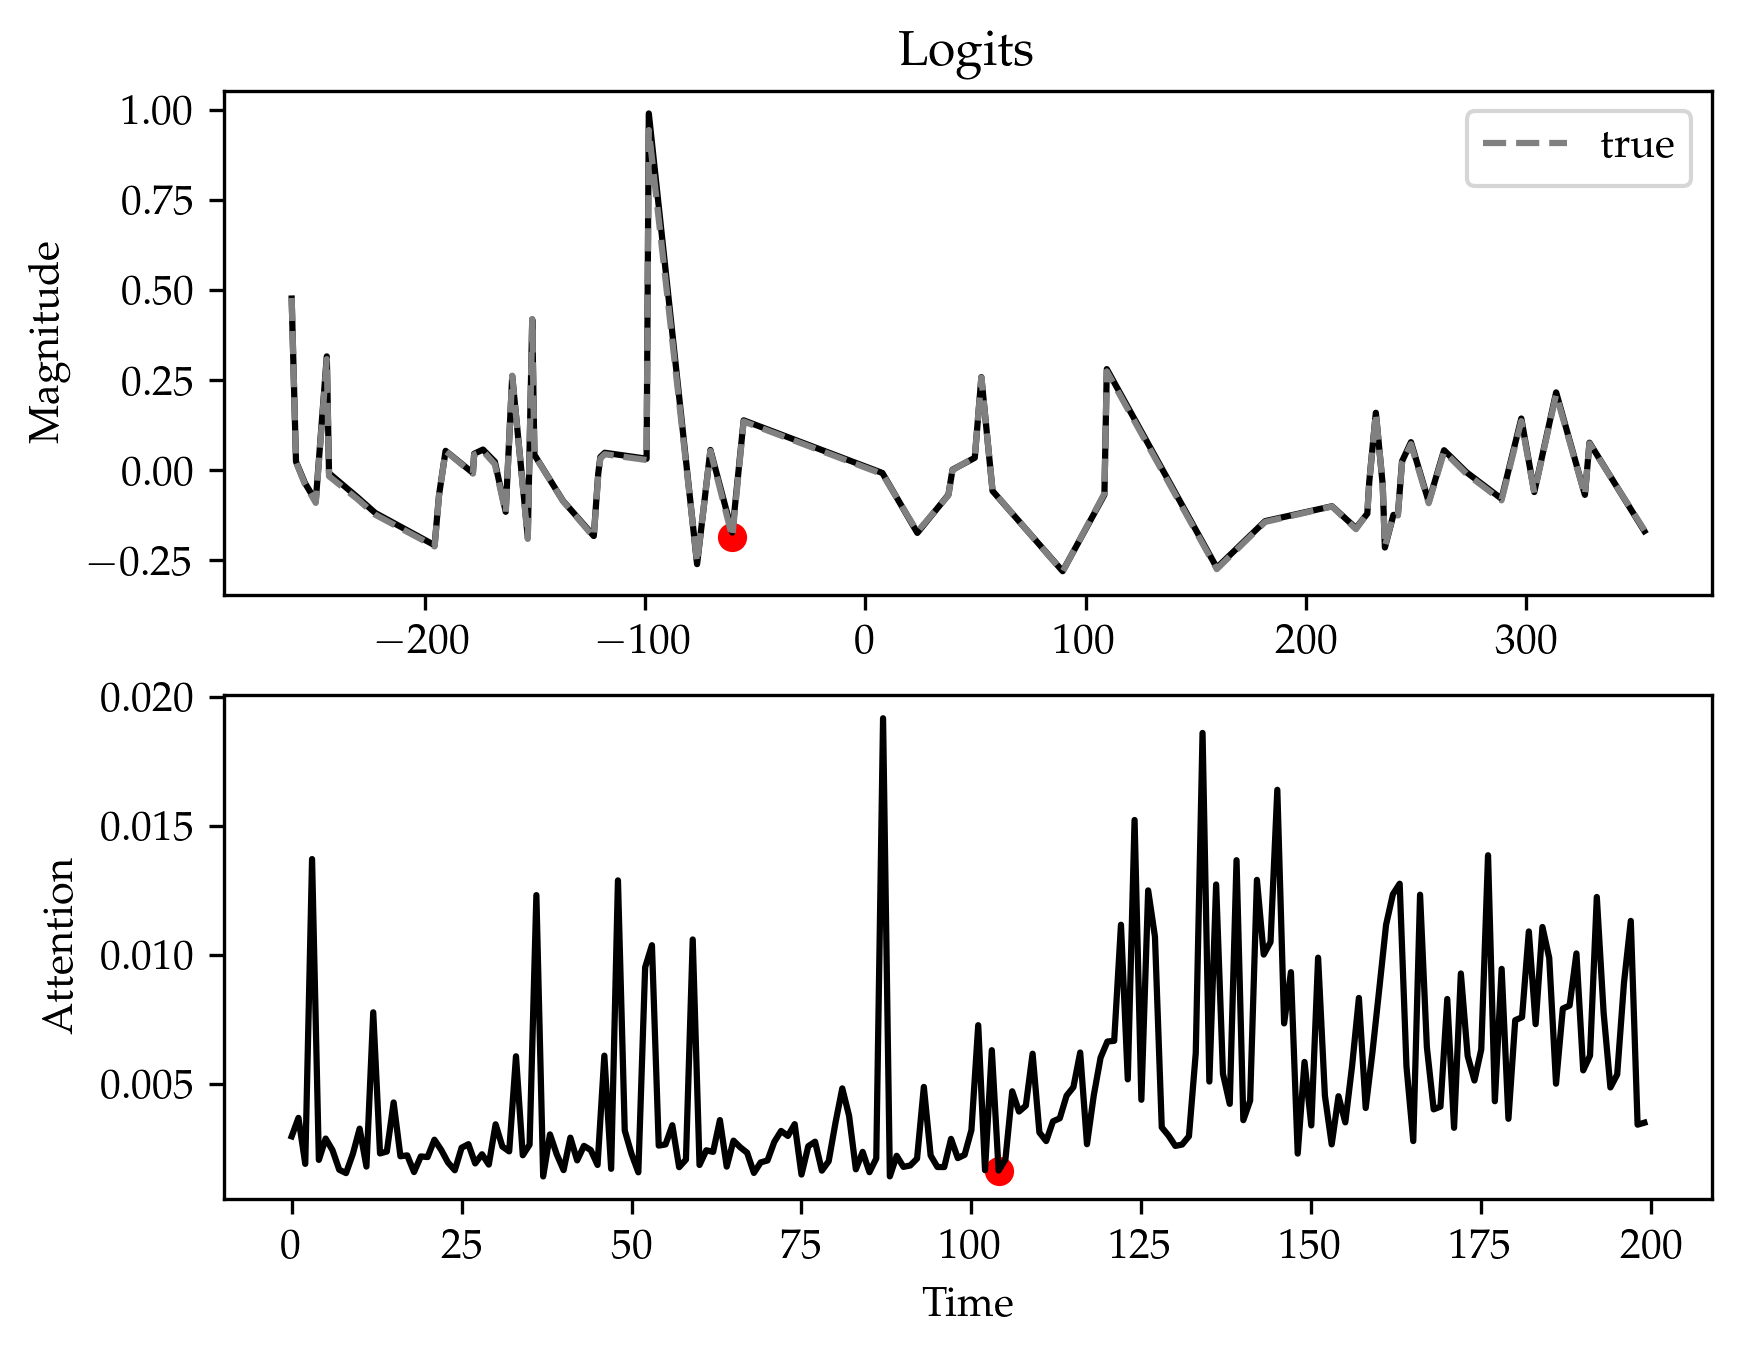

In [319]:
N = 1


fig, axes = plt.subplots(ncols=1, nrows=2, dpi=300)

valid_y = tf.boolean_mask(y['target'][N], x['mask_in'][N])
valid_x = tf.boolean_mask(x_rec[N], x['mask_in'][N])
valid_t = tf.boolean_mask(x['times'][N], x['mask_in'][N])

att_values = tf.boolean_mask(w[N, 0], x['mask_in'][N,...,0])


OBS_N = 29
axes[0].plot(valid_t, valid_x, color='k', marker='')
axes[0].plot(valid_t, valid_y, label='true', color='grey', linestyle='--')
axes[0].scatter(valid_t[OBS_N], valid_y[OBS_N], color='red')

axes[0].legend()

xrange = np.arange(x['times'][N].shape[0])
partial = tf.boolean_mask(att_values[OBS_N], x['mask_in'][N,...,0])
partial_xrange = tf.boolean_mask(xrange, x['mask_in'][N,...,0]) 

axes[1].plot(xrange, att_values[OBS_N], color='k')
axes[1].scatter(partial_xrange[OBS_N], partial[OBS_N], color='r')

axes[1].set_ylabel('Attention')
axes[0].set_ylabel('Magnitude')
axes[1].set_xlabel('Time')
axes[0].set_title('Logits')

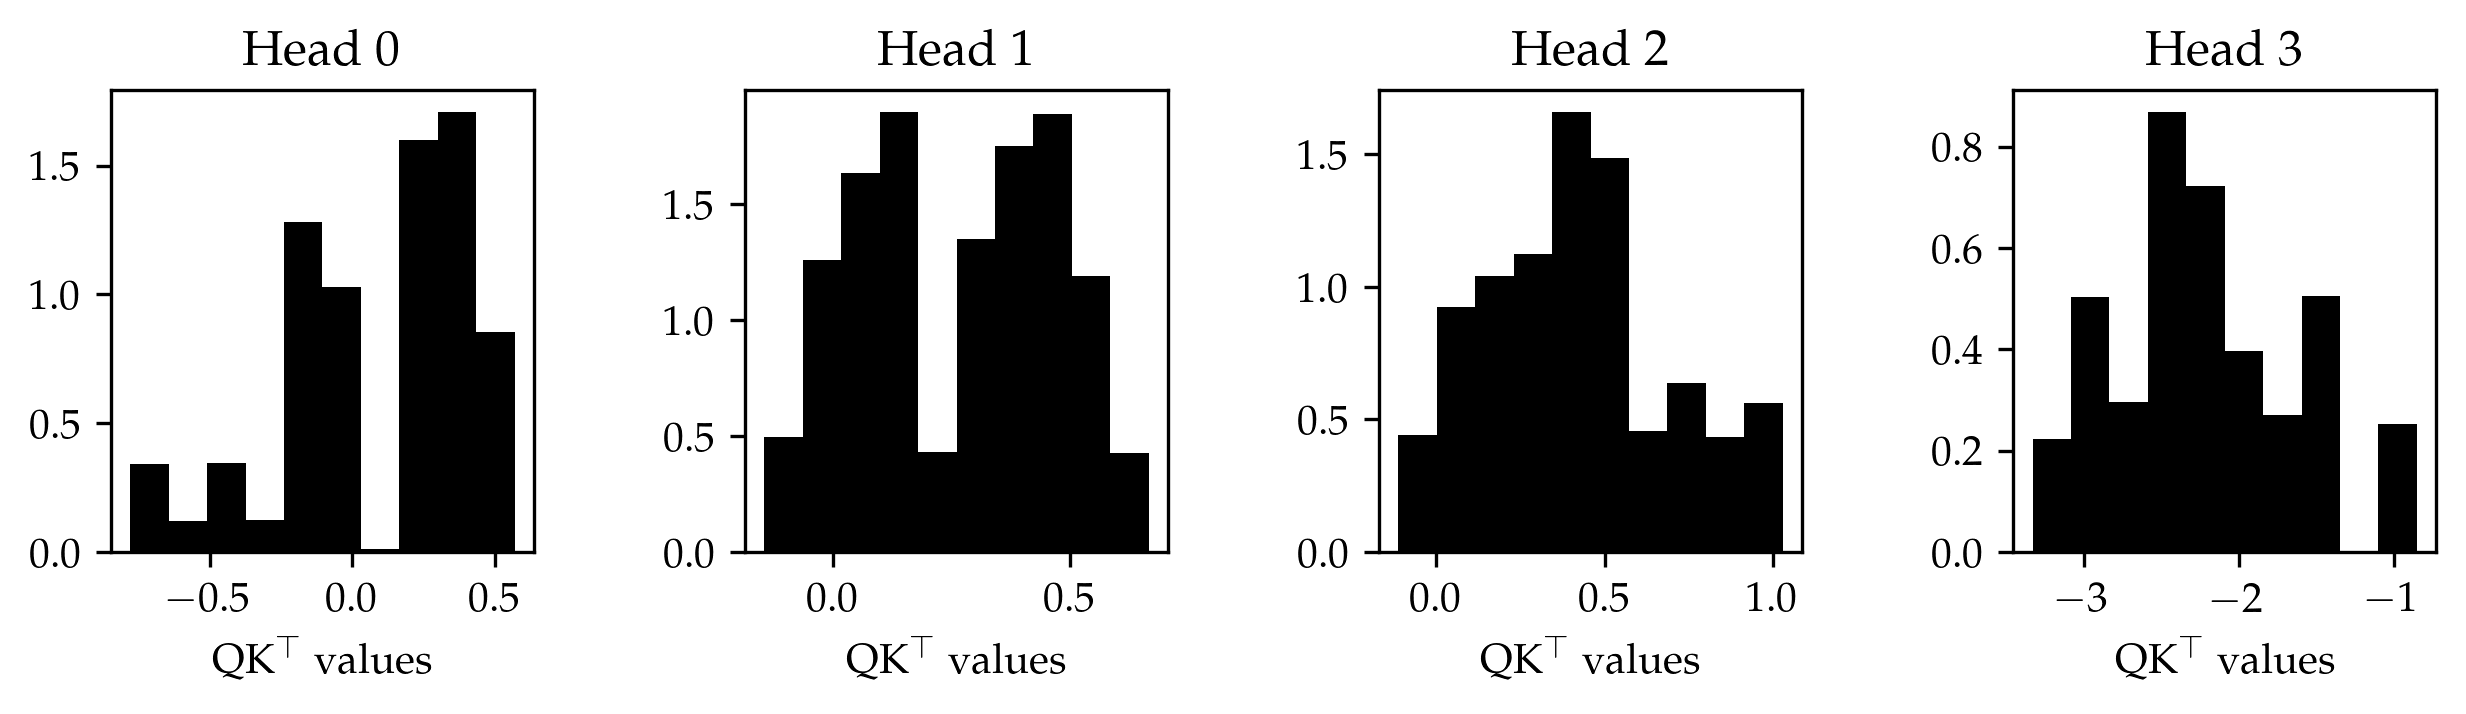

In [131]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2), gridspec_kw={'wspace':0.5}, dpi=300)
for h in range(4):
    qk_values = output['qk_values'][:, h]
    qk_values = qk_values.numpy().flatten()
    axes[h].hist(qk_values, density=True, color='black')
    axes[h].set_title('Head {}'.format(h))
    axes[h].set_xlabel(r'$\rm{QK^{\top}}$ values')
plt.show()

In [132]:
def norm_vector(norm):
    minv = min(norm)
    maxv = max(norm)
    return (norm - minv)/(maxv - minv)

Text(0.5, 0, 'Step')

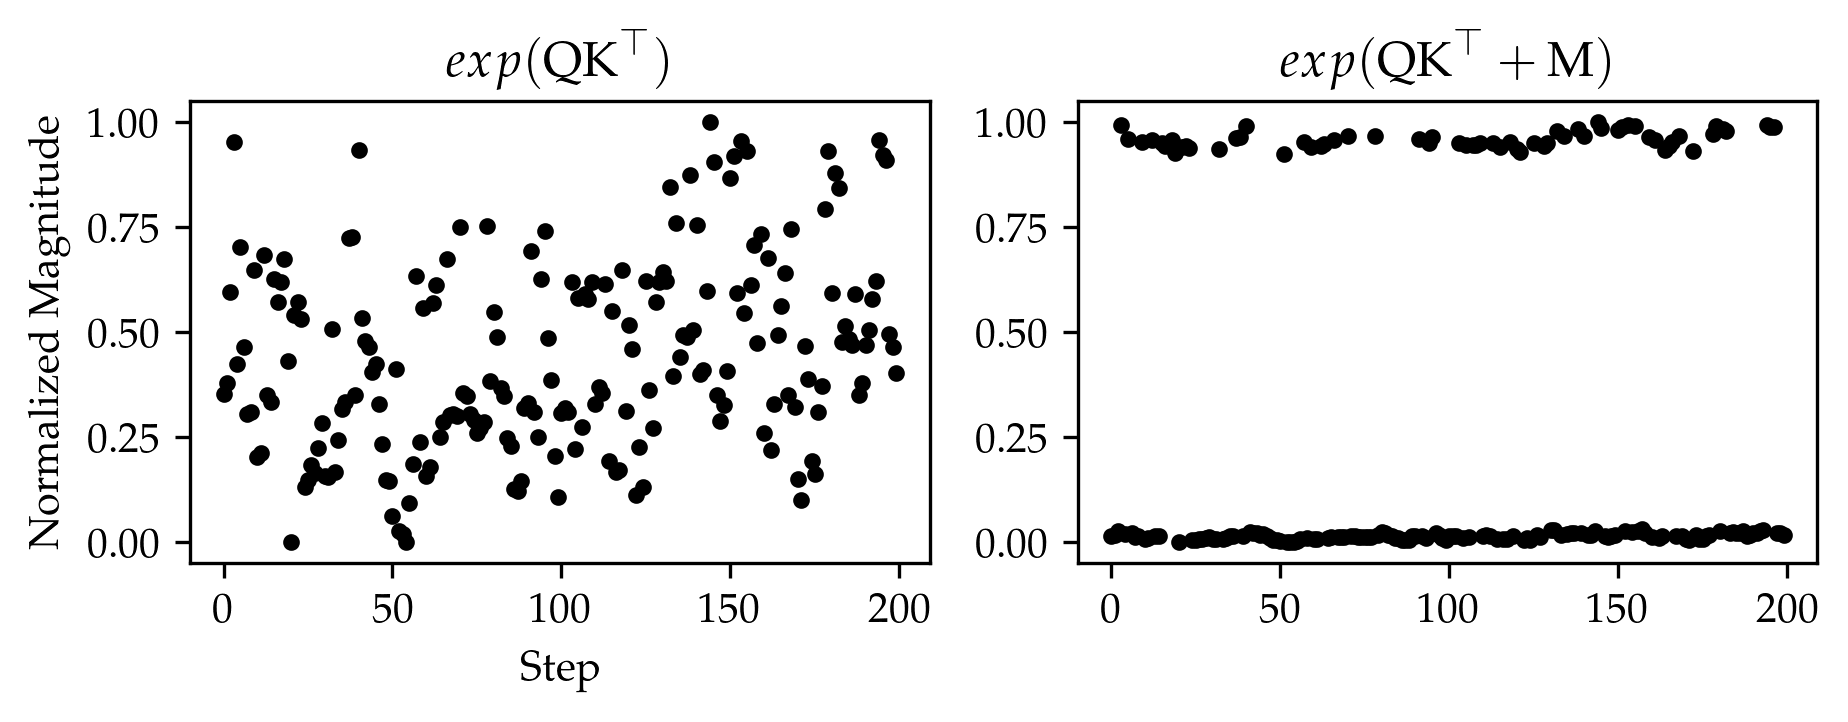

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2), dpi=300)
axes[1].plot(norm_vector(output['w'][0, 0, 0]), color='k', marker='.', linestyle='')
axes[0].plot(norm_vector(output['qk_values'][0, 0, 0]), color='k', marker='.', linestyle='')
axes[0].set_title(r'$exp(\rm{QK}^{\top})$')
axes[1].set_title(r'$exp(\rm{QK}^{\top} + \rm{M})$')
axes[0].set_ylabel('Normalized Magnitude')
axes[0].set_xlabel('Step')
axes[0].set_xlabel('Step')

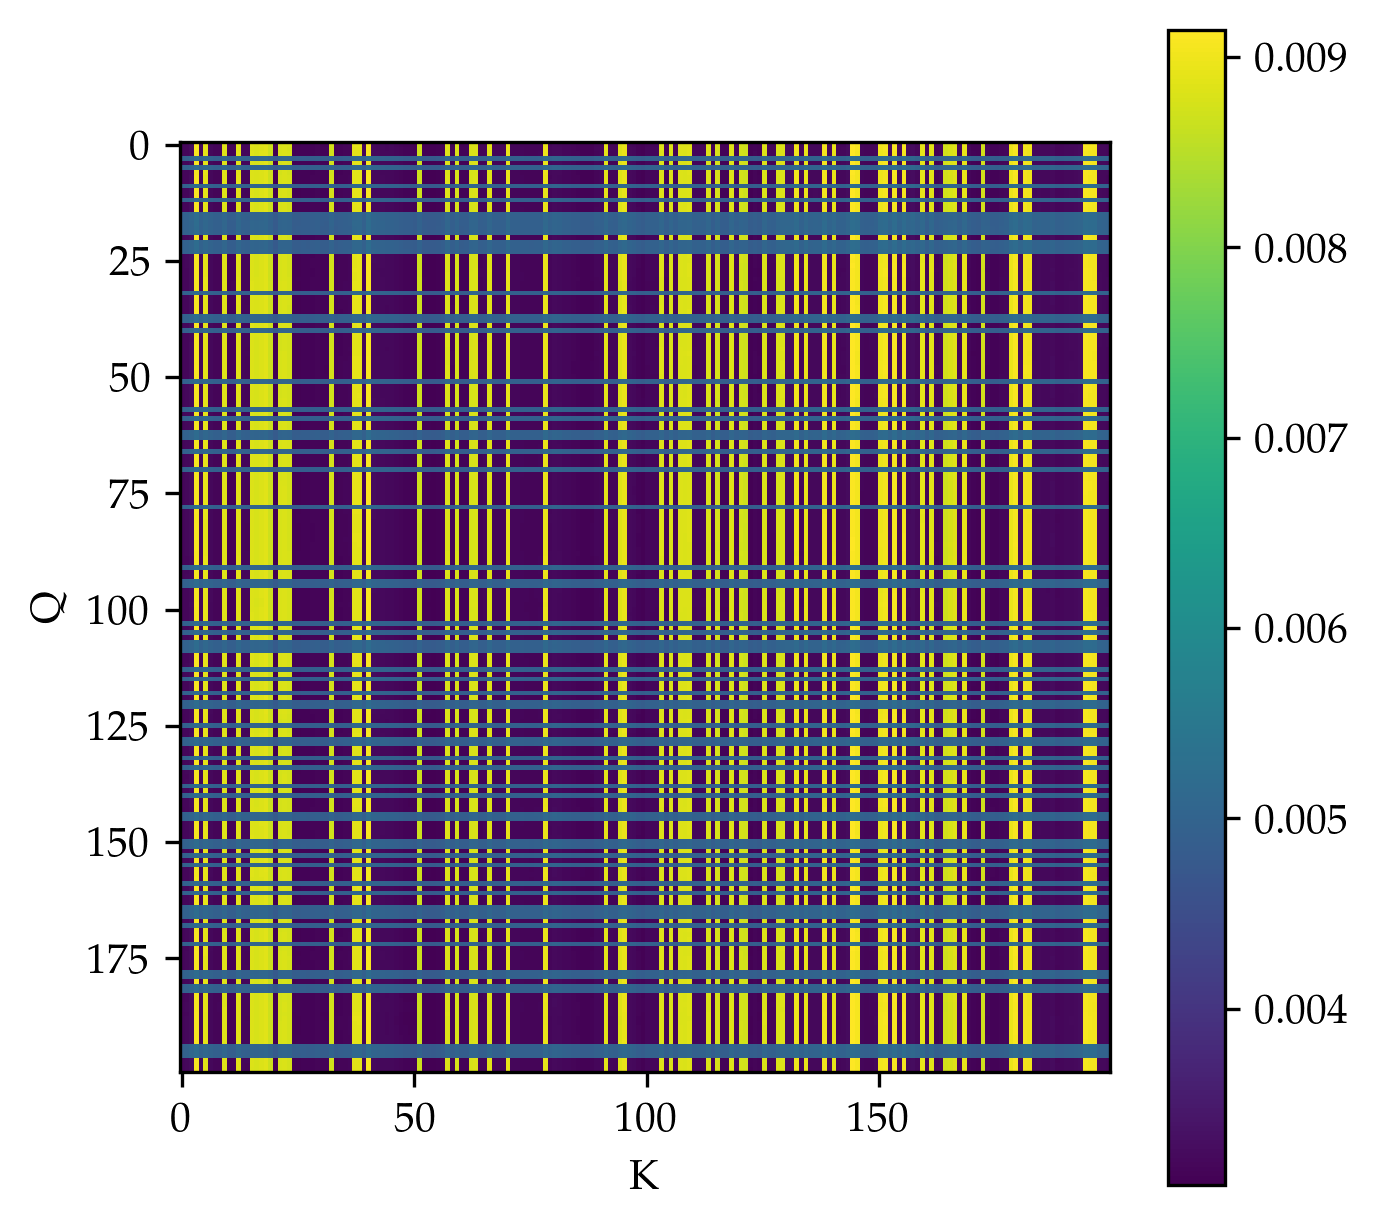

In [137]:
plt.figure(figsize=(5,5), dpi=300)
plt.imshow(output['w'][0, 0])
plt.ylabel('Q')
plt.xlabel('K')
plt.colorbar()

In [12]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import matplotlib.patches as patches

# init_index=42
# N = 14
# cosim_matrix = cosine_similarity(avg_att[init_index:init_index+N], 
#                                  avg_att[init_index:init_index+N])
# roid = emb_dict['oid'][:N]
# q = pd.DataFrame(roid, columns=['oid']).groupby('oid').size()

# fig, axes = plt.subplots(1, 1, figsize = (10,10))

# im = axes.imshow(cosim_matrix, interpolation='nearest', cmap='viridis')
# axes.set_xticks(range(N))
# axes.set_xticklabels(roid, rotation=90, fontsize=13)
# axes.xaxis.tick_top()
# axes.set_yticks(range(N))
# axes.set_yticklabels(roid, fontsize=13)

# n_windows = [q[l] for l in roid]
# pivot = -.5
# last = ''
# for size, idd in zip(n_windows, roid):
#     if last == idd: continue
#     rect = patches.Rectangle((pivot, pivot), 
#                              size, size, 
#                              linewidth=2, 
#                              edgecolor='k', 
#                              facecolor='none')
#     pivot+=size
#     last = idd
   
#     # Add the patch to the Axes
#     axes.add_patch(rect)

# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')

# for i, j in np.ndindex(N, N):
    
#     axes.text(i-0.4, j+0.1, 
#               '{:.3f}'.format(cosim_matrix[i][j]), fontsize=13)


# plt.show()